# Vodafone Music Challenge

---
## Опис проєкту
Метою проєкту є побудова моделі машинного навчання для прогнозування ймовірності того, що абонент мобільного оператора встановить та оплатить сервіс Vodafone Music протягом одного місяця після дати скорингу.

Тип задачі: **бінарна класифікація**

Цільова змінна (target):

* `1` — встановив і оплатив
* `0` — не встановив

Модель повинна прогнозувати не просто клас, а ймовірність встановлення сервісу, що дозволяє бізнесу гнучко обирати поріг відбору клієнтів для кампанії.

Метрика оцінювання: **ROC-AUC**

---

## Дані

Дані містять інформацію про абонентів та їхню поведінку.

Основні групи ознак:

- `Device characteristics` — характеристики пристрою
- `General characteristics` — загальні характеристики абонента
- `User activity features` — активність користувача
- `All costs` — витрати за місяць
- `Recharge statistics` — статистика поповнень
- `Voice costs & duration` — голосові витрати та тривалість дзвінків
- `Network action stats` — мережеві події
- `Other Essential Features` — використання інших сервісів (зокрема дата-трафік)  
- `SMS from Services` — кількість вхідних SMS від різних сервісів  
- `Interests data` — інтереси та використання сервісів
- `Previous campaigns results` — участь у попередніх кампаніях

Агрегати розраховані за:
- `m1` — попередній місяць
- `m2` — другий попередній місяць
- `m3` - третій місяць


## 1. Імпорт необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Завантаження даних

In [2]:
bucket = "tkachenko-ml-dataset"
music_df = pd.read_csv(f"s3://{bucket}/train_music.csv")
music_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 461 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    id                                   70000 non-null  int64  
 1    target                               70000 non-null  int64  
 2    device_type                          70000 non-null  int64  
 3    manufacturer_category                70000 non-null  int64  
 4    os_category                          70000 non-null  int64  
 5    sim_count                            69301 non-null  float64
 6    tp_flag                              70000 non-null  int64  
 7    lt                                   70000 non-null  float64
 8    block_flag                           70000 non-null  int64  
 9    days_exp                             69993 non-null  float64
 10   service_1_flag                       69993 non-null  float64
 11   service_1_cou

**Усі ознаки є числовими (float64 та int64). Категоріальні змінні відсутні. Датасет повністю готовий до використання в ML-моделях без додаткового кодування. містить багато пропущених значень.**

## 3. Попередня обробка

In [3]:
# Розмірність датасету
print("Shape:", music_df.shape)
print("Rows:", music_df.shape[0])
print("Columns:", music_df.shape[1])

Shape: (70000, 461)
Rows: 70000
Columns: 461


**Датасет містить 70 000 спостережень та 461 ознаку.
Обсяг даних достатній для побудови стабільної моделі.**

In [4]:
# Частка пропусків
missing = music_df.isnull().mean().sort_values(ascending=False)
missing.head(20)

count_url_category_13    0.992771
count_url_category_15    0.987029
count_app_3              0.986643
vol_app_3                0.986643
count_url_category_12    0.983129
vol_app_11               0.977329
count_app_11             0.977329
count_app_13             0.973143
vol_app_13               0.973143
count_url_category_1     0.972186
count_gift_type_4        0.969586
rr_gift_type_4           0.969586
count_app_16             0.967171
vol_app_16               0.967171
count_app_14             0.964086
vol_app_14               0.964086
count_url_category_11    0.948486
service_9_flag_m3        0.947871
service_9_flag_m1        0.945414
service_9_flag_m2        0.945157
dtype: float64

In [5]:
# Усі знайдені пропуски у csv файл
missing_counts = music_df.isnull().sum()
missing_counts[missing_counts > 0].to_csv("missing_columns.csv")

**Аналіз пропусків показав, що значна частина ознак містить високий рівень пропущених значень, зокрема деякі змінні мають понад 90% NaN.**

In [6]:
# Target Distribution
target_counts = music_df['target'].value_counts()
target_percentage = music_df['target'].value_counts(normalize=True)
print(target_counts)
print(target_percentage)

target
0    64699
1     5301
Name: count, dtype: int64
target
0    0.924271
1    0.075729
Name: proportion, dtype: float64


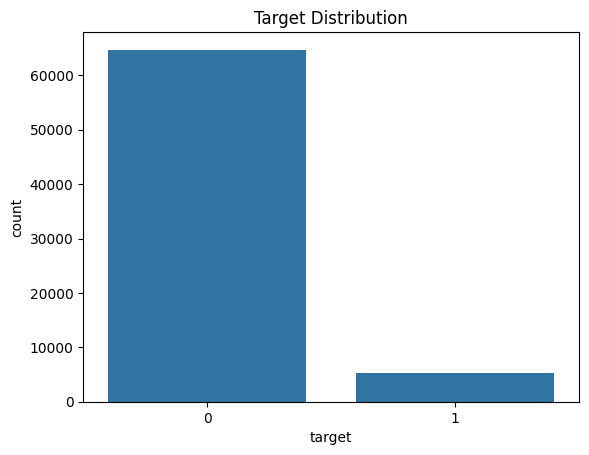

In [7]:
sns.countplot(x='target', data=music_df)
plt.title("Target Distribution")
plt.show()


**Частка позитивного класу становить `7.57%`, тоді як негативний клас — `92.43%`.**

**Датасет є суттєво незбалансованим, що необхідно враховувати під час навчання моделі.**

In [8]:
# Ключові слова, які можуть вказувати на leakage
suspicious_keywords = [
    'music', 'install', 'payment', 'future', 
    'next', 'subscription'
]

# Пошук колонок
leakage_cols = [
    col for col in music_df.columns
    if any(word in col.lower() for word in suspicious_keywords)
]

leakage_cols


[]

In [9]:
corr_with_target = music_df.corr()['target'].sort_values(ascending=False)

# Топ-10 найбільш корельованих ознак
corr_with_target.head(10)

target               1.000000
id                   0.154761
content_count_m1     0.116450
vol_app_11           0.112219
content_count_m3     0.111245
count_app_11         0.103440
content_count_m2     0.094392
count_gift_type_3    0.081626
count_app_5          0.076582
count_act_type_6     0.073582
Name: target, dtype: float64

In [10]:
# Чи є колонка, яка повністю дорівнює target
for col in music_df.columns:
    if col != 'target':
        if music_df[col].equals(music_df['target']):
            print("Leakage found:", col)


In [11]:
# Перевірка кореляції id з target
music_df[['id', 'target']].corr()


,id,target
id,1.000000,0.154761
target,0.154761,1.000000


**Підозрілих колонок, що містять інформацію про майбутні події або прямо пов’язані з встановленням сервісу, не виявлено.
Кореляційний аналіз не показав ознак із кореляцією, близькою до 1, що свідчило б про прямий витік інформації.
Колонка `id` має бути виключена з набору ознак перед навчанням моделі, оскільки вона є технічним ідентифікатором.**

## 4. Очищення даних

In [13]:
# Рахуємо частку пропусків і відокремлюємо фічі з більш ніж 95% пропущених значень
missing_ratio = music_df.isnull().mean()

high_missing_thresh = 0.95
high_missing_cols = missing_ratio[missing_ratio > high_missing_thresh].index.tolist()

print("Columns with >95% missing:", len(high_missing_cols))
high_missing_cols[:20]


Columns with >95% missing: 16


['count_url_category_1',
 'count_url_category_12',
 'count_url_category_13',
 'count_url_category_15',
 'vol_app_3',
 'vol_app_11',
 'vol_app_13',
 'vol_app_14',
 'vol_app_16',
 'count_app_3',
 'count_app_11',
 'count_app_13',
 'count_app_14',
 'count_app_16',
 'rr_gift_type_4',
 'count_gift_type_4']

In [14]:
# Видаляємо фічі з надто великою часткою NaN
music_df = music_df.drop(columns=high_missing_cols)
print("Shape after dropping high-missing cols:", music_df.shape)


Shape after dropping high-missing cols: (70000, 445)


**Виявлено 16 ознак із часткою пропусків понад 95%. Такі ознаки містять недостатньо інформації для ефективного навчання моделі, тому були видалені.**

In [15]:
# Заповнюємо решту пропусків нулями
music_df = music_df.fillna(0)
music_df.isnull().sum().sum()

0

In [17]:
# Перевіримо наявність нескінченності
num_cols = music_df.columns.drop(['target'], errors='ignore')

inf_mask = np.isinf(music_df[num_cols]).any()
print("Any inf:", inf_mask)

# якщо є inf — замінюємо на NaN і потім на 0
music_df[num_cols] = music_df[num_cols].replace([np.inf, -np.inf], np.nan)
music_df[num_cols] = music_df[num_cols].fillna(0)


Any inf: id                       False
device_type              False
manufacturer_category    False
os_category              False
sim_count                False
                         ...  
income_brnd_cont_m3      False
data_type_1_m3           False
data_type_2_m3           False
data_type_3_m3           False
service_9_flag_m3        False
Length: 444, dtype: bool


**Аналіз показав, що у датасеті відсутні значення типу `inf` або `-inf`. 
Додаткове очищення цього типу аномалій не потребується.**

In [18]:
# Наявність негативних значень
neg_counts = (music_df[num_cols] < 0).sum().sort_values(ascending=False)
neg_counts = neg_counts[neg_counts > 0]
neg_counts.head(20)


balance_sum            1211
pay_out_P2P_cost_m2     971
pay_out_P2P_cost_m1     960
pay_out_P2P_cost_m3     898
days_exp                535
paym_el_sum_m3            4
paym_sum_m3               4
paym_sum_m2               2
paym_el_sum_m2            2
paym_el_sum_m1            2
paym_sum_m1               2
dtype: int64

In [19]:
# Замінюємо всі негативні значення на 0
music_df[num_cols] = music_df[num_cols].clip(lower=0)


**Виявлено 11 ознак із негативними значеннями. Такі ознаки є некоректними, тому були замінені на 0.**

In [21]:
# Константні ознаки (лише 1 унікальне значення)
constant_cols = [c for c in music_df.columns if c not in ['target', 'id'] and music_df[c].nunique() <= 1]
print("Constant columns:", len(constant_cols))
constant_cols[:20]


Constant columns: 17


['rr_act_type_7',
 'rr_gift_type_1',
 'pay_out_P2P_cost_m1',
 'voice_omo_in_cost_m1',
 'voice_pstn_in_cost_m1',
 'sms_roam_in_count_m1',
 'service_8_count_m1',
 'pay_out_P2P_cost_m2',
 'voice_omo_in_cost_m2',
 'voice_pstn_in_cost_m2',
 'sms_roam_in_count_m2',
 'service_8_count_m2',
 'pay_out_P2P_cost_m3',
 'voice_omo_in_cost_m3',
 'voice_pstn_in_cost_m3',
 'sms_roam_in_count_m3',
 'service_8_count_m3']

In [22]:
music_df = music_df.drop(columns=constant_cols)
print("Shape after dropping constant cols:", music_df.shape)


Shape after dropping constant cols: (70000, 428)


**Було виявлено 17 константних ознак, що мають лише одне унікальне значення в усьому датасеті. Такі змінні не містять інформативності та не можуть впливати на модель, тому вони були видалені. Після очищення кількість ознак зменшилась до 428.**

In [23]:
# Майже константні (одне значення займає, наприклад, ≥ 99.5%)
near_const_thresh = 0.995  # 99.5%

near_constant_cols = []
for c in music_df.columns:
    if c in ['target', 'id']:
        continue
    top_freq = music_df[c].value_counts(normalize=True, dropna=False).iloc[0]
    if top_freq >= near_const_thresh:
        near_constant_cols.append(c)

print("Near-constant columns:", len(near_constant_cols))
near_constant_cols[:20]


Near-constant columns: 47


['service_2_flag',
 'inact_days_count',
 'count_sms_source_1',
 'count_sms_source_2',
 'sms_roam_cost_m1',
 'voice_pstn_out_cost_m1',
 'voice_roam_out_cost_m1',
 'voice_onnet_cc_dur_m1',
 'voice_omo_cc_dur_m1',
 'voice_pstn_out_dur_m1',
 'voice_pstn_out_count_m1',
 'voice_onnet_cc_count_m1',
 'voice_omo_cc_count_m1',
 'sms_onnet_out_pack_count_m1',
 'sms_omo_out_pack_count_m1',
 'sms_roam_out_count_m1',
 'service_5_count_m1',
 'sms_roam_cost_m2',
 'voice_pstn_out_cost_m2',
 'voice_roam_out_cost_m2']

In [27]:
music_df = music_df.drop(columns=near_constant_cols, errors='ignore')
print("Shape after dropping near-constant cols:", music_df.shape)

Shape after dropping near-constant cols: (70000, 381)


**Було виявлено 47 майже константних ознак, у яких одне значення домінує у більш ніж 99% спостережень. Такі змінні мають низьку інформативність та були видалені. Після очищення кількість ознак скоротилась до 381.**

In [28]:
# id не використовуємо як фічу
X = music_df.drop(columns=['target', 'id'], errors='ignore')
y = music_df['target'].copy()
print(X.shape, y.shape)

(70000, 379) (70000,)


**Колонка `id` була виключена як технічний ідентифікатор, що не несе інформативної цінності.**

In [29]:
music_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 381 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    id                                   70000 non-null  int64  
 1    target                               70000 non-null  int64  
 2    device_type                          70000 non-null  int64  
 3    manufacturer_category                70000 non-null  int64  
 4    os_category                          70000 non-null  int64  
 5    sim_count                            70000 non-null  float64
 6    tp_flag                              70000 non-null  int64  
 7    lt                                   70000 non-null  float64
 8    block_flag                           70000 non-null  int64  
 9    days_exp                             70000 non-null  float64
 10   service_1_flag                       70000 non-null  float64
 11   service_1_cou

**У результаті маємо очищений датасет без шумових фіч та без пропусків, готовий до подальшої обробки та навчання**